In [1]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV
from sklearn.metrics import accuracy_score,precision_score, classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("../data/clean/merged.csv")

# Convert "playoff" column to binary (Y: 1, N: 0)
df["playoff"] = df["playoff"].map({"Y": 1, "N": 0})
df.head()

,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,avg_team_last_year_allPF,avg_team_last_year_allFGA,avg_team_last_year_allTR,avg_team_last_year_allTRA,avg_team_last_year_allMinutes,num_players_joined,num_players_left,num_players_changed_team,award_points_coach,last_year_mean_wins_coach
0,ATL,9,EA,0.0,3.5,2079.8,640.9,502.7,1077.6,520.7,...,55.259615,166.201122,17.840144,49.144631,510.537660,14.0,9.0,23.0,0.0,1.026701
1,ATL,10,EA,1.0,7.0,2258.0,725.0,598.0,1077.0,492.0,...,54.361367,169.501920,17.682412,55.124040,526.865207,8.0,13.0,21.0,1.0,0.133333
2,ATL,11,EA,NaN,2.0,2428.0,755.0,374.0,1259.0,547.0,...,56.603550,203.643491,12.802515,41.376479,638.306213,0.0,0.0,0.0,0.0,1.000000
3,CHA,1,EA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.676768,178.505051,16.609091,49.047475,574.079798,13.0,8.0,21.0,0.0,0.000000
4,CHA,2,EA,1.0,8.0,1903.0,577.0,386.0,935.0,551.0,...,70.366267,198.638224,21.541417,62.973054,686.959581,7.0,3.0,10.0,0.0,0.391304


### Label Encoding

In [3]:
from sklearn.preprocessing import LabelEncoder

def encode_df(df):
    le = LabelEncoder()
    tmID_mapping = {} 
    
    for col, col_type in df.dtypes.items():
        if col_type == 'object' or col_type == 'datetime64[ns]':
            # store mapping if the column is 'tmID'
            if col == 'tmID':
                df[col] = le.fit_transform(df[col])
                tmID_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
            else:
                df[col] = le.fit_transform(df[col])
                
    return df, tmID_mapping

# Use the function to encode the dataframe and get the tmID mapping
df, tmID_mapping = encode_df(df)


df.head(10)

,tmID,year,confID,playoff,last_year_rank,last_year_o_fga,last_year_o_fta,last_year_o_3pa,last_year_o_reb,last_year_o_asts,...,avg_team_last_year_allPF,avg_team_last_year_allFGA,avg_team_last_year_allTR,avg_team_last_year_allTRA,avg_team_last_year_allMinutes,num_players_joined,num_players_left,num_players_changed_team,award_points_coach,last_year_mean_wins_coach
0,0,9,0,0.0,3.5,2079.8,640.9,502.7,1077.6,520.7,...,55.259615,166.201122,17.840144,49.144631,510.537660,14.0,9.0,23.0,0.0,1.026701
1,0,10,0,1.0,7.0,2258.0,725.0,598.0,1077.0,492.0,...,54.361367,169.501920,17.682412,55.124040,526.865207,8.0,13.0,21.0,1.0,0.133333
2,0,11,0,NaN,2.0,2428.0,755.0,374.0,1259.0,547.0,...,56.603550,203.643491,12.802515,41.376479,638.306213,0.0,0.0,0.0,0.0,1.000000
3,1,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,54.676768,178.505051,16.609091,49.047475,574.079798,13.0,8.0,21.0,0.0,0.000000
4,1,2,0,1.0,8.0,1903.0,577.0,386.0,935.0,551.0,...,70.366267,198.638224,21.541417,62.973054,686.959581,7.0,3.0,10.0,0.0,0.391304
5,1,3,0,1.0,4.0,1780.0,528.0,428.0,948.0,467.0,...,52.101873,163.185019,14.962547,44.767041,556.393258,4.0,6.0,10.0,0.0,1.222222
6,1,4,0,1.0,2.0,1790.0,663.0,527.0,955.0,496.0,...,54.248485,161.560606,10.450000,29.219697,516.807576,4.0,4.0,8.0,0.0,1.124761
7,1,5,0,0.0,2.0,1881.0,590.0,517.0,971.0,499.0,...,53.480250,206.604046,17.827071,48.765414,616.022158,7.0,7.0,14.0,0.0,1.000000
8,1,6,0,0.0,5.0,1744.0,590.0,459.0,872.0,426.0,...,59.354549,220.876611,19.361187,55.106599,651.615775,9.0,9.0,18.0,0.0,1.190826
9,1,6,0,0.0,5.0,1744.0,590.0,459.0,872.0,426.0,...,59.354549,220.876611,19.361187,55.106599,651.615775,9.0,9.0,18.0,0.0,0.888889


### Data Balancing

In [4]:
def calculate_class_distribution_similarity(df, y_train, y_test):
    # Step 1: Calculate class distribution in the original dataset
    original_class_distribution = df['playoff'].value_counts(normalize=True)
    print("Original Class Distribution:")
    print(original_class_distribution)

    # Step 2: Calculate class distribution in the training and test sets
    train_class_distribution = y_train.value_counts(normalize=True)
    test_class_distribution = y_test.value_counts(normalize=True)

    print("\nTraining Set Class Distribution:")
    print(train_class_distribution)
    print("\nTest Set Class Distribution:")
    print(test_class_distribution)

    # Step 3: Compare class distributions
    class_distribution_similarity = (train_class_distribution - test_class_distribution).abs().sum()
    print("\nClass Distribution Similarity Score:", class_distribution_similarity)

    return class_distribution_similarity

# Update the train_model function to include imputation
def train_model(df, year):
    # Remove rows with missing values
    df.dropna(inplace=True)

    teams_df_train = df[df['year'] < year]
    teams_df_test = df[df['year'] == year]

    

    X_train, y_train = teams_df_train.drop(columns=['playoff']), teams_df_train['playoff']
    X_test, y_test = teams_df_test.drop(columns=['playoff']), teams_df_test['playoff']

    print(f"\nTrain/Test size for year={year}:", X_train.shape, X_test.shape, y_train.shape, y_test.shape)

    # Initialize SMOTE
    smote = SMOTE(random_state=42)
    # Fit SMOTE on the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


    return X_train_resampled, y_train_resampled, X_test, y_test

# create a final dataset with the predictions: team, playoff, prediction (a probability between 0 and 1)
def create_predictions(df, year, model, distribution_similarity=True):
    # Create a copy of the original dataset
    new_df = df.copy()

    X_train, y_train, X_test, y_test = train_model(new_df, year)

    # Check if the class distribution is similar between the training and test sets
    if distribution_similarity:
        calculate_class_distribution_similarity(new_df, y_train, y_test)    

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test) # Predictions
    y_pred_proba = model.predict_proba(X_test) # Prediction probabilities

    # Only add predictions to the test set
    new_df.loc[new_df['year'] == year, 'prediction'] = y_pred
    new_df.loc[new_df['year'] == year, 'prediction_proba'] = y_pred_proba[:,1]

    # Filter the dataset to only include the year we are interested in
    new_df = new_df[new_df['year'] == year]

    # Convert the predictions to integers
    new_df['prediction'] = new_df['prediction'].astype(int)

    return new_df

def calculate_error(res_df):
    # normalize the prediction probabilities so they sum up to 8
    res_df['prediction_proba'] = res_df['prediction_proba'] * 8 / res_df['prediction_proba'].sum()

    # Calculate the error
    error = (res_df['playoff'] - res_df['prediction_proba']).abs().sum()
    return error


Training model: Logistic Regression

Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)

Training model: Random Forest

Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 6

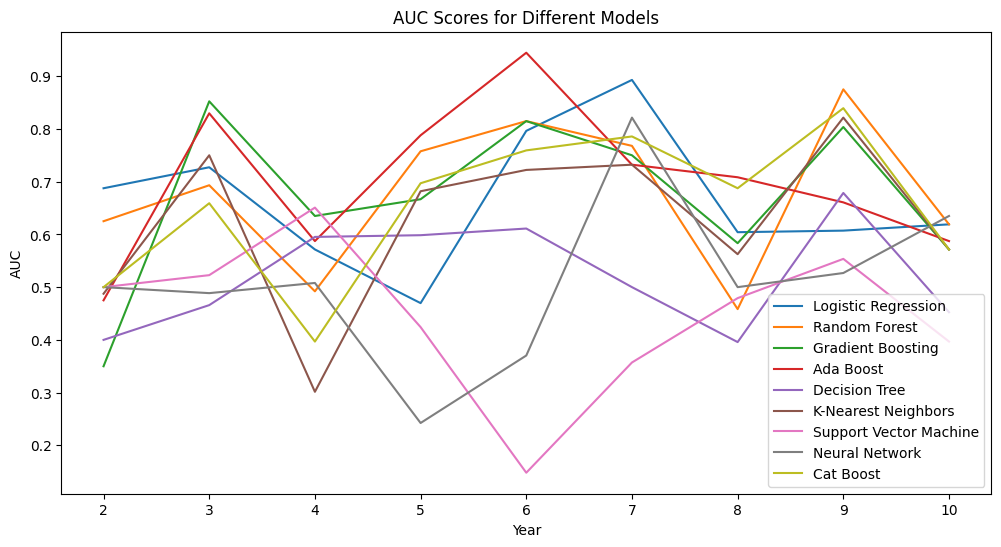

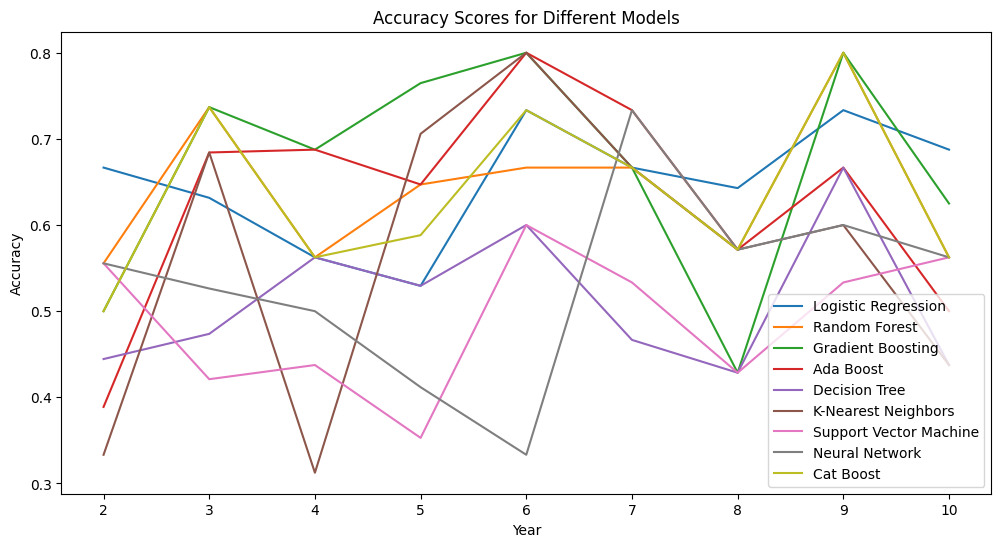

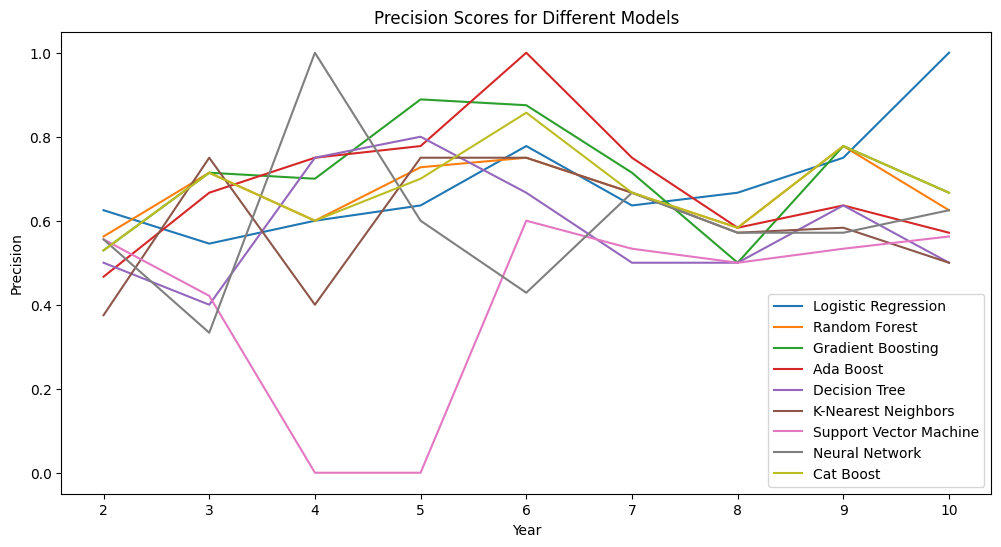

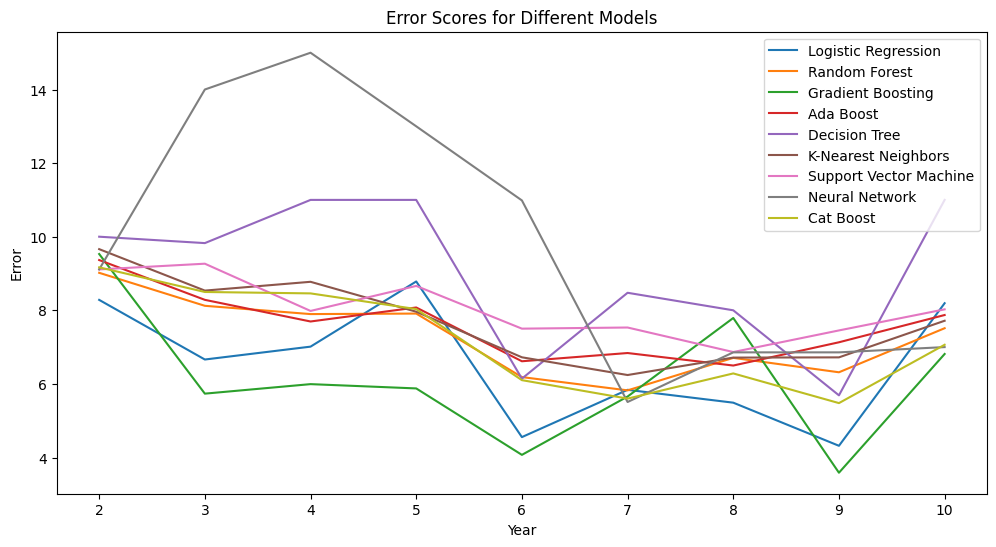

In [5]:
# Test various models and see which one performs the best
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=1000),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3),
    "Ada Boost": AdaBoostClassifier(),
    "Decision Tree": DecisionTreeClassifier(max_depth=10, min_samples_split=5),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=8, weights='distance'),
    "Support Vector Machine": SVC(probability=True),
    "Neural Network": MLPClassifier(solver='adam'),
    "Cat Boost": CatBoostClassifier()
}

min_year = 2
max_year = 10

# Create a dictionary to store the AUC, accuracy and precision scores for each model
auc_scores = {}
accuracy_scores = {}
precision_scores = {}
error_scores = {}

for name, model in models.items():
    print(f"\nTraining model: {name}")
    auc_scores[name] = []
    accuracy_scores[name] = []
    precision_scores[name] = []
    error_scores[name] = []

    for i in range(min_year, max_year + 1):
        new_df = create_predictions(df, i, model, distribution_similarity=False)
        
        auc_scores[name].append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
        accuracy_scores[name].append(accuracy_score(new_df['playoff'], new_df['prediction']))
        precision_scores[name].append(precision_score(new_df['playoff'], new_df['prediction']))
        error_scores[name].append(calculate_error(new_df))
        

# Plot the AUC scores for each model
plt.figure(figsize=(12, 6))

for name, scores in auc_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("AUC")
plt.title("AUC Scores for Different Models")
plt.legend()
plt.show()

# Plot the accuracy scores for each model
plt.figure(figsize=(12, 6))

for name, scores in accuracy_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Different Models")
plt.legend()
plt.show()

# Plot the precision scores for each model
plt.figure(figsize=(12, 6))

for name, scores in precision_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision Scores for Different Models")
plt.legend()
plt.show()

# Plot the error scores for each model
plt.figure(figsize=(12, 6))

for name, scores in error_scores.items():
    plt.plot(range(min_year, max_year + 1), scores, label=name)

plt.xlabel("Year")
plt.ylabel("Error")
plt.title("Error Scores for Different Models")
plt.legend()
plt.show()


Train/Test size for year=2: (17, 60) (18, 60) (17,) (18,)

Train/Test size for year=3: (35, 60) (19, 60) (35,) (19,)

Train/Test size for year=4: (54, 60) (16, 60) (54,) (16,)

Train/Test size for year=5: (70, 60) (17, 60) (70,) (17,)

Train/Test size for year=6: (87, 60) (15, 60) (87,) (15,)

Train/Test size for year=7: (102, 60) (15, 60) (102,) (15,)

Train/Test size for year=8: (117, 60) (14, 60) (117,) (14,)

Train/Test size for year=9: (131, 60) (15, 60) (131,) (15,)

Train/Test size for year=10: (146, 60) (16, 60) (146,) (16,)


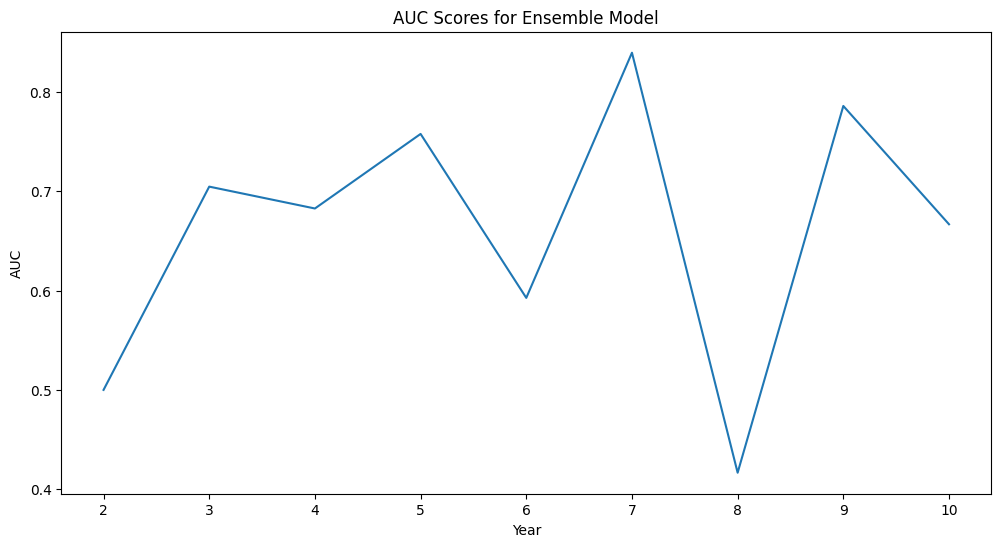

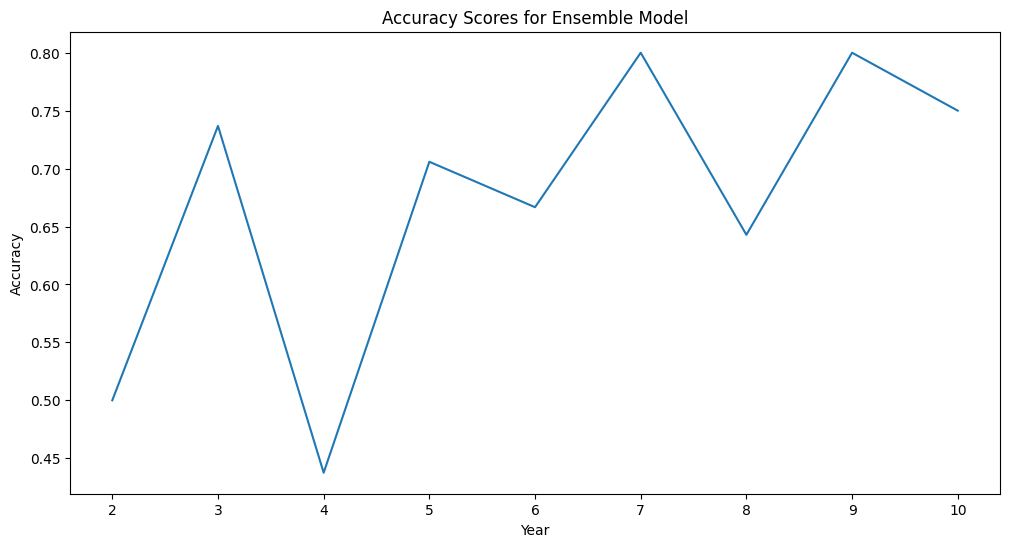

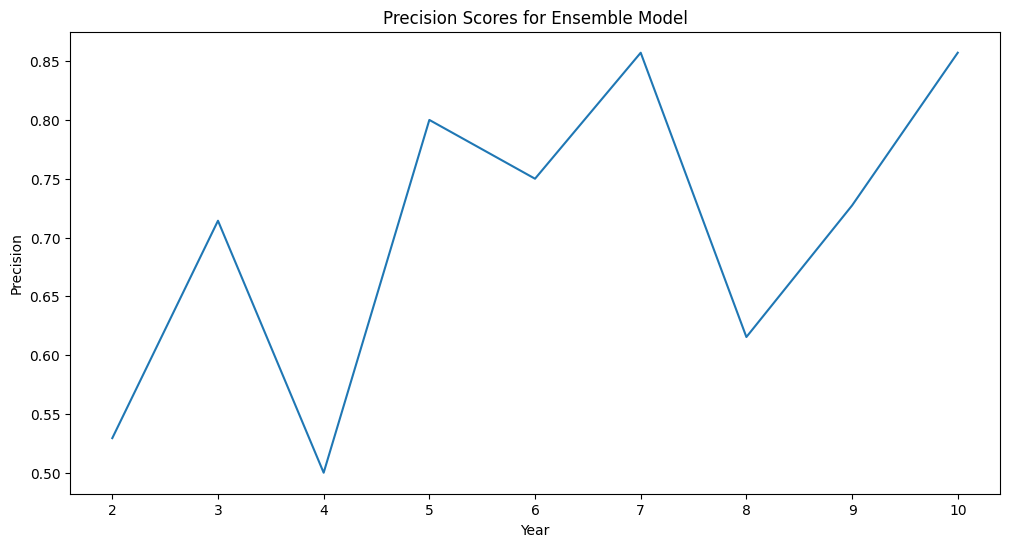

In [83]:
# Test various models and see which one performs the best
models = {
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=1000, learning_rate=0.3),
    "Ada Boost": AdaBoostClassifier(n_estimators=1000, learning_rate=0.3),
    "Neural Network": MLPClassifier(max_fun=20000)
}

ensemble_model = VotingClassifier(estimators=[('rf', RandomForestClassifier()), ('gb', GradientBoostingClassifier()), ('ab', AdaBoostClassifier()), ('nn', MLPClassifier())], voting='soft')

ensemble_auc_scores = []
ensemble_accuracy_scores = []
ensemble_precision_scores = []

for i in range(min_year, max_year + 1):
    new_df = create_predictions(df, i, ensemble_model, distribution_similarity=False)
    ensemble_auc_scores.append(roc_auc_score(new_df['playoff'], new_df['prediction_proba']))
    ensemble_accuracy_scores.append(accuracy_score(new_df['playoff'], new_df['prediction']))
    ensemble_precision_scores.append(precision_score(new_df['playoff'], new_df['prediction']))

# Plot the AUC scores for the ensemble model
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year + 1), ensemble_auc_scores)
plt.xlabel("Year")
plt.ylabel("AUC")
plt.title("AUC Scores for Ensemble Model")
plt.show()

# Plot the accuracy scores for the ensemble model
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year + 1), ensemble_accuracy_scores)
plt.xlabel("Year")
plt.ylabel("Accuracy")
plt.title("Accuracy Scores for Ensemble Model")
plt.show()

# Plot the precision scores for the ensemble model
plt.figure(figsize=(12, 6))
plt.plot(range(min_year, max_year + 1), ensemble_precision_scores)
plt.xlabel("Year")
plt.ylabel("Precision")
plt.title("Precision Scores for Ensemble Model")
plt.show()

